In [116]:
import winsound
import matplotlib.pyplot as plt
import numpy as np
from skimage import morphology as mp
import cv2
from operator import itemgetter

In [117]:
frequency = 2500
duration = 1000


In [118]:
winsound.Beep(frequency, duration)

In [119]:
twinkle = cv2.imread("Twinkle_Twinkle_Sheet_Music.png")
twinkle = cv2.cvtColor(twinkle, cv2.COLOR_BGR2GRAY)
s1 = cv2.imread("s1.jpg")
s1 = cv2.cvtColor(s1, cv2.COLOR_BGR2GRAY)
s2 = cv2.imread("s2.jpg")
s2 = cv2.cvtColor(s2, cv2.COLOR_BGR2GRAY)
t1 = cv2.imread("template_1.png")
t1 = cv2.cvtColor(t1, cv2.COLOR_BGR2GRAY)
t2 = cv2.imread("template_2.png")
t2 = cv2.cvtColor(t2, cv2.COLOR_BGR2GRAY)
t3 = cv2.imread("template_3.png")
t3 = cv2.cvtColor(t3, cv2.COLOR_BGR2GRAY)

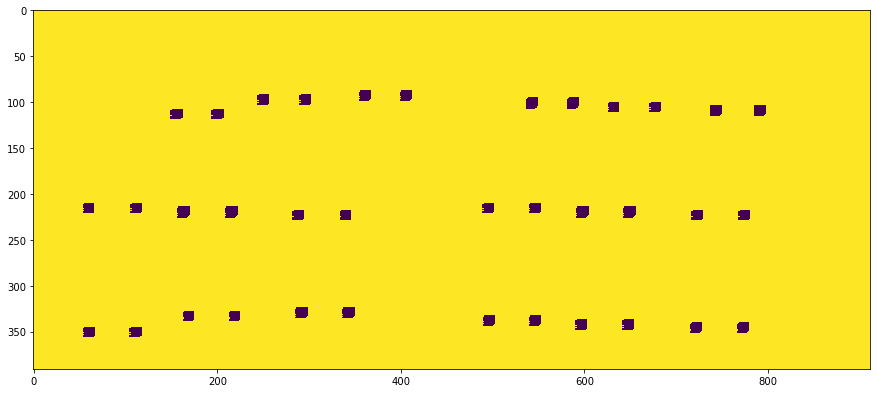

In [120]:
#from skimage import morphology
t = 0.3
blur = cv2.GaussianBlur(src = twinkle, ksize = (11,11), sigmaX = 1)
(t, binary) = cv2.threshold(src = blur,
    thresh = t, 
    maxval = 1, 
    type = cv2.THRESH_BINARY)
notes = mp.erosion(binary,s2)
notes = (notes*255).astype('uint8')
plt.figure(figsize = [15,10])
plt.imshow(notes)

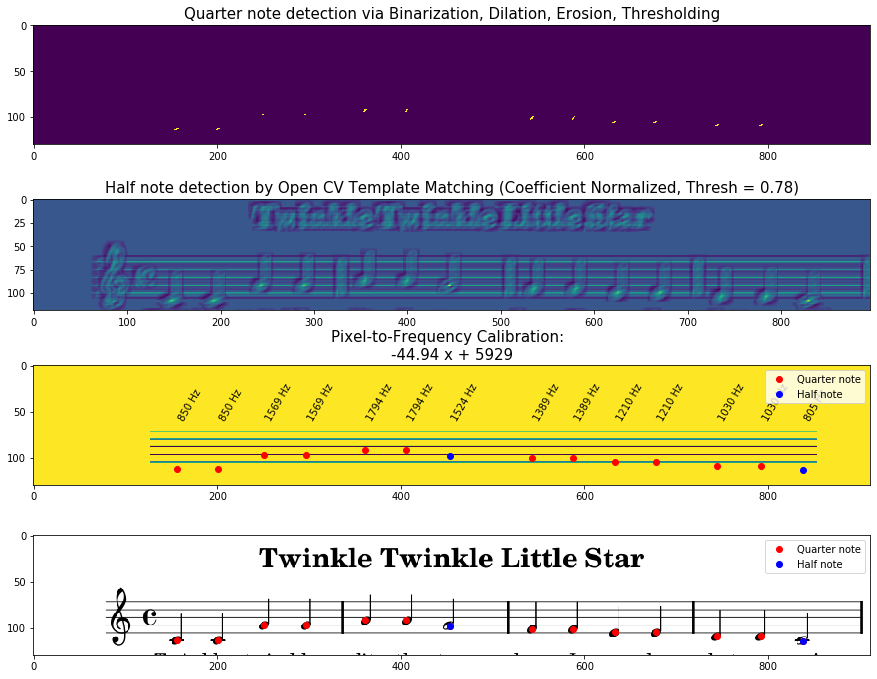

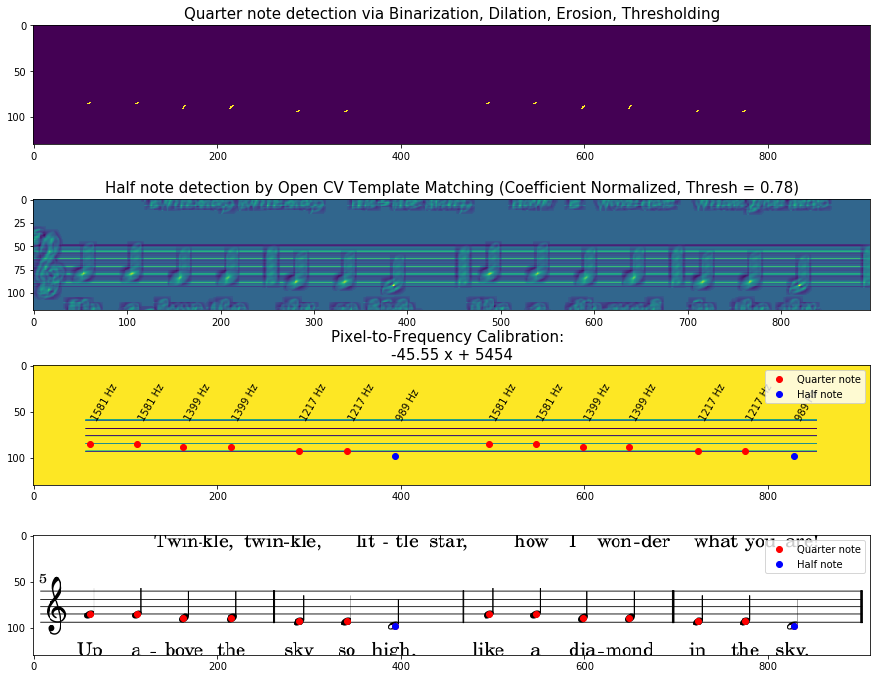

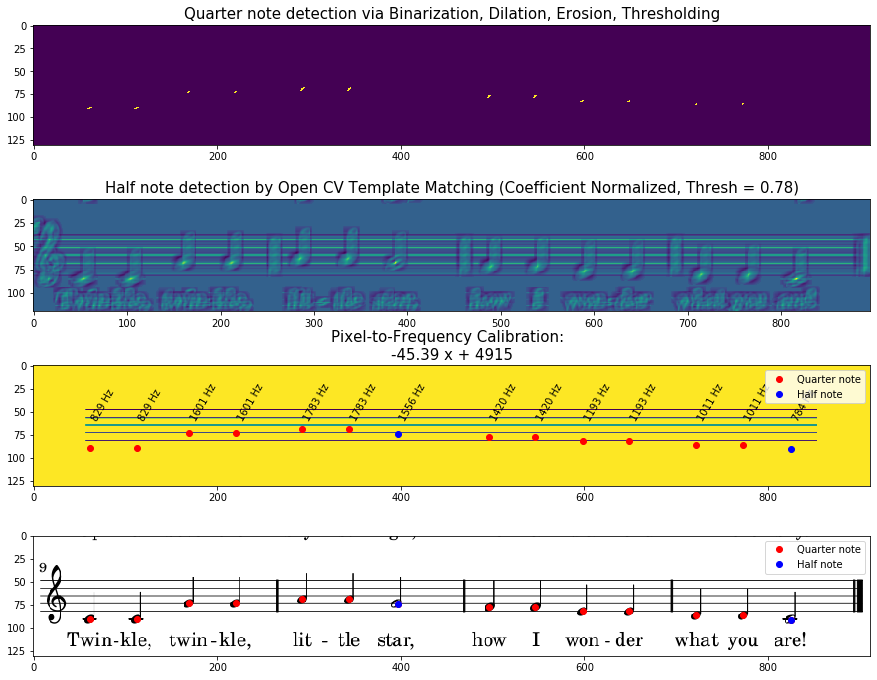

In [207]:
def pix_to_freq_1(pix, Y):
    #freq = [698, 587, 494, 392, 330]
    # [F5,D5,B5,G4,E4]
    #freq = [1396.91, 1174.66, 987.77,783.99,659.25]
    #freq_calib = [2793.83, 2349.32, 1975.53, 1567.98, 1318.51]
    freq_calib = [F7,D7,B7,G6,E6]
    z1 = np.polyfit(Y, freq_calib, 1)
    p1 = np.poly1d(z1)
    freq = pix*p1[1] + p1[0]
    return freq, p1


FREQUENCIES = []
X_COORD = []
Y_COORD = []
DURATION = []

sections = 3
image = binary
shape = image.shape

for s in range(sections):

    section = image[s*shape[0]//sections:(s+1)*shape[0]//3,:]
    ret,thresh = cv2.threshold(section.astype('uint8'),0,255,1)
    contours,hierarchy = cv2.findContours(thresh, 1, 2)
    CX, CY = [],[]
    for j in range(len(contours[:])):
        cnt = contours[j]
        M = cv2.moments(cnt)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        CX.append(cx)
        CY.append(cy)

    size1 = 100
    s1 = np.zeros(shape=[size1,size1])
    s1[size1//2,:] = 1

    staff = mp.dilation(twinkle,s1)
    staff_sec = staff[s*shape[0]//sections:(s+1)*shape[0]//sections,:]


    y = np.where(staff_sec[:,500] < 255)[0]
    Y = []
    for k in range(1,len(y)+1):
        if np.abs(y[k-2]-y[k-1]) > 2:
            Y.append(y[k-1])

    notes_freq = []
    duration = []
    for cy in CY:
        f, equation = pix_to_freq_1(cy, Y)
        #FREQUENCIES.append(int(f))
        notes_freq.append(int(f))
        duration.append(500)

    section_half = twinkle[s*shape[0]//sections:(s+1)*shape[0]//3,:]
    res_half = cv2.matchTemplate(section_half,t3,cv2.TM_CCOEFF_NORMED)


    threshold = 0.78
    loc = np.where( res_half >= threshold)
    x_half = loc[1]+w/2
    y_half = loc[0]+h/2
        
    
    
    plt.figure(figsize = [15,12])
    plt.rcParams.update({'font.size' : 10})
    plt.rcParams['axes.titlesize'] = 15
    #plt.suptitle("Staff #" + str(s+1))
    plt.subplot(4,1,1)
    plt.title("Quarter note detection via Binarization, Dilation, Erosion, Thresholding")
    plt.imshow(thresh)
    plt.subplot(4,1,2)
    plt.title("Half note detection by Open CV Template Matching (Coefficient Normalized, Thresh = 0.78)")

    plt.imshow(res_half)

    plt.subplot(4,1,3)
    plt.imshow(staff_sec)
    plt.plot(CX, CY, 'ro')
    plt.plot(x_half, y_half, 'bo')
    
    


    for i in range(len(y_half)):
        f_half, equation = pix_to_freq_1(y_half[i], Y)
        notes_freq.append(int(f_half))
        duration.append(1000)
        CX.append(x_half[i])
        CY.append(y_half[i])
        
    for cxcx in range(len(CX)):
        plt.text(CX[cxcx],60, str(notes_freq[cxcx]) + " Hz", rotation = 60)
    plt.legend(["Quarter note", "Half note"])
    plt.title("Pixel-to-Frequency Calibration: " + str(equation) )
    plt.subplot(4,1,4)
    plt.imshow(section_half, cmap = 'gray')
    plt.plot(CX, CY, 'ro')
    plt.plot(x_half, y_half, 'bo')
    plt.legend(["Quarter note", "Half note"])

        
    indices, CX_sorted= zip(*sorted(enumerate(CX), key=itemgetter(1)))
    CY_sorted = []
    for z in indices:
        CY_sorted.append(CY[z])
        Y_COORD.append(CY[z]+s*shape[0]//sections)
        X_COORD.append(CX[z])
        FREQUENCIES.append(notes_freq[z])
        DURATION.append(duration[z])
        
#     plt.figure(figsize = [20,2])
#     plt.title("Staff #" + str(s+1))
#     plt.imshow(section_half)
#     plt.plot(CX, CY, 'ro')
    
 
    plt.show()
#     print("Y locations of notes:" + str(CY_sorted))
#     print("Calibration Curve:" + str(equation))
    #print("Note Frequencies:" + str(notes_freq))
    #print("Duration:" + str(duration))
    


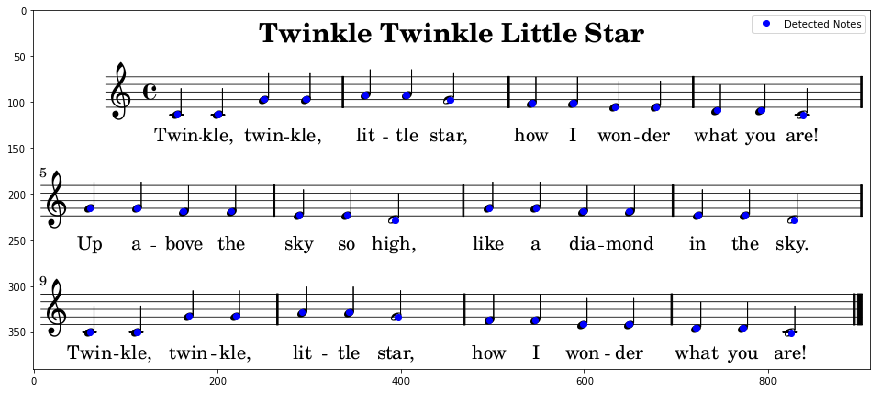

In [188]:

plt.figure(figsize = [15,10])
plt.imshow(twinkle, cmap = "gray")
plt.plot(X_COORD, Y_COORD, 'bo')
plt.legend(["Detected Notes"])

In [206]:
C6 = 1046.50
D6 = 1174.66
E6 = 1318.51
F6 = 1396.91
G6 = 1567.98
A6 = 1760
B7 = 1975.53
C7 = 2093
D7 = 2349.32
E7 = 2637.02
F7 = 2793.83
G7 = 3135.96
A8 = 3520
B8 = 3951.07


In [189]:
Theoretical_F = [C6, C6, G6, G6, A6, A6, G6, F6, F6, E6, E6, D6, D6, C6,
                 G6, G6, F6, F6, E6, E6, D6, G6, G6, F6, F6, E6, E6, D6,
                 C6, C6, G6, G6, A6, A6, G6, F6, F6, E6, E6, D6, D6, C6]

In [147]:
len(Theoretical_F), len(FREQUENCIES)

(42, 42)

In [208]:
for m in range(len(FREQUENCIES)):
    winsound.Beep(FREQUENCIES[m],DURATION[m])

In [151]:
for m in range(len(Theoretical_F)):
    winsound.Beep(int(Theoretical_F[m]),DURATION[m])

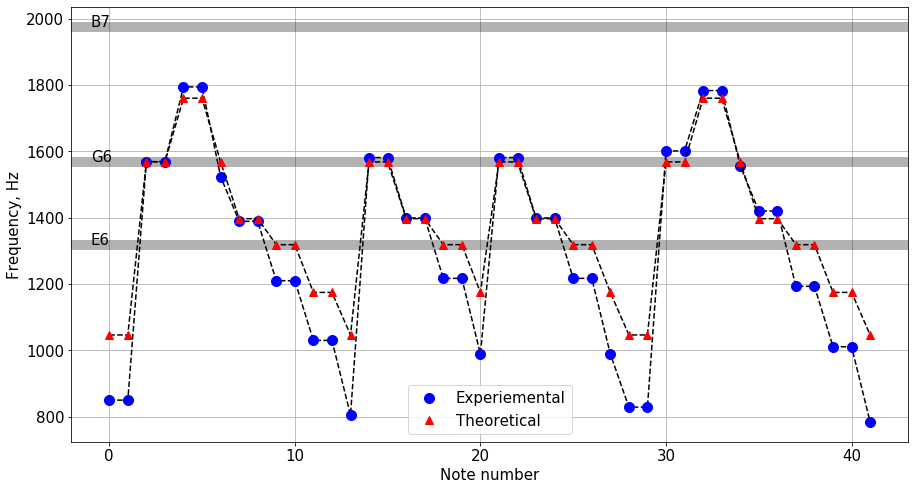

In [228]:
plt.figure(figsize = [15,8], facecolor = 'w')
plt.rcParams.update({'font.size' : 15})
plt.rcParams['axes.titlesize'] = 15
plt.axhline(E6, color = 'k', lw = 10, alpha = 0.3)
plt.axhline(G6, color = 'k', lw = 10, alpha = 0.3)
plt.axhline(B7, color = 'k', lw = 10, alpha = 0.3)
plt.plot(FREQUENCIES, 'k--')
plt.plot(FREQUENCIES, 'bo', ms = 10, label = "Experiemental")
plt.plot(Theoretical_F, 'k--')
plt.plot(Theoretical_F, 'r^',ms = 8, label = "Theoretical")
plt.xlabel("Note number")
plt.ylabel("Frequency, Hz")
plt.text(-1,E6,"E6")
plt.text(-1,G6,"G6")
plt.text(-1,B7,"B7")
#plt.axhline(D7, color = 'g')
#plt.axhline(F7, color = 'g')
plt.legend()
plt.grid()

In [59]:
np.min(FREQUENCIES),np.max(FREQUENCIES)

(784, 1794)

In [175]:
def pix_to_freq_1(pix, Y):
    #freq = [698, 587, 494, 392, 330]
    # [F5,D5,B5,G4,E4]
    #freq_calib = [1396.91, 1174.66, 987.77,783.99,659.25]
    freq_calib = [2793.83, 2349.32, 1975.53, 1567.98, 1318.51]
    z1 = np.polyfit(Y, freq_calib, 1)
    p1 = np.poly1d(z1)
    freq = pix*p1[1] + p1[0]
    return freq, p1

s = 0
sections = 3
image = binary 
shape = binary.shape
FREQUENCIES = []
X_COORD = []
Y_COORD = []
DURATION = []

section = image[s*shape[0]//sections:(s+1)*shape[0]//3,:]
ret,thresh = cv2.threshold(section.astype('uint8'),0,255,1)
contours,hierarchy = cv2.findContours(thresh, 1, 2)
CX, CY = [],[]
for j in range(len(contours[:])):
    cnt = contours[j]
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    CX.append(cx)
    CY.append(cy)

size1 = 100
s1 = np.zeros(shape=[size1,size1])
s1[size1//2,:] = 1

staff = mp.dilation(twinkle,s1)
staff_sec = staff[s*shape[0]//sections:(s+1)*shape[0]//sections,:]


y = np.where(staff_sec[:,500] < 255)[0]
Y = []
for k in range(1,len(y)+1):
    if np.abs(y[k-2]-y[k-1]) > 2:
        Y.append((y[k-1]+y[k-2])/2)
    else: Y.append((y[k-1]))



# notes_freq = []
# duration = []
# for cy in CY:
#     f, equation = pix_to_freq_1(cy, Y)
#     #FREQUENCIES.append(int(f))
#     notes_freq.append(int(f))
#     duration.append(500)

# section_half = twinkle[s*shape[0]//sections:(s+1)*shape[0]//3,:]
# res_half = cv2.matchTemplate(section_half,t3,cv2.TM_CCOEFF_NORMED)


# threshold = 0.78
# loc = np.where( res_half >= threshold)

# w, h = t3.shape[::-1]
# x_half = loc[1]#+h/2
# y_half = loc[0]#+w/2

# # print(CX, CY, notes_freq)
# # print(x_half, y_half)

# for i in range(len(y_half)):
#     f_half, equation = pix_to_freq_1(y_half[i], Y)
#     notes_freq.append(int(f_half))
#     duration.append(1000)
#     CX.append(x_half[i])
#     CY.append(y_half[i])

# # print(CX, CY, notes_freq)
# indices, CX_sorted= zip(*sorted(enumerate(CX), key=itemgetter(1)))
# CY_sorted = []
# for z in indices:
#     CY_sorted.append(CY[z])
#     Y_COORD.append(CY[z]+s*shape[0]//sections)
#     X_COORD.append(CX[z])
#     FREQUENCIES.append(notes_freq[z])
#     DURATION.append(duration[z])
    
# plt.figure(figsize = [20,5])
# plt.imshow(res_half)
# plt.plot(x_half, y_half, 'ro')
# plt.colorbar()
# plt.show()

In [173]:
for m in range(len(FREQUENCIES)):
    winsound.Beep(FREQUENCIES[m],DURATION[m])

In [31]:
x_half

array([385, 820], dtype=int64)

In [235]:
CX, x_half

([775, 724, 341, 289, 649, 598, 215, 163, 547, 496, 113, 61, 393.5, 393.5],
 array([393.5, 828.5]))

In [32]:
for y_h in y_half:
    index = y_half.tolist().index(y_h)
    print(index)

0
0


In [231]:
X_COORD, Y_COORD, FREQUENCIES, DURATION

([61, 113, 163, 215, 289, 341, 393.5, 393.5, 496, 547, 598, 649, 724, 775],
 [215, 215, 219, 219, 223, 223, 228.0, 228.0, 215, 215, 219, 219, 223, 223],
 [1581,
  1581,
  1399,
  1399,
  1217,
  1217,
  989,
  989,
  1581,
  1581,
  1399,
  1399,
  1217,
  1217],
 [500, 500, 500, 500, 500, 500, 1000, 1000, 500, 500, 500, 500, 500, 500])

In [185]:
def pix_to_freq_1(pix, Y):
    #freq = [698, 587, 494, 392, 330]
    # [F5,D5,B5,G4,E4]
    #freq_calib = [1396.91, 1174.66, 987.77,783.99,659.25]
    freq_calib = [2793.83, 2349.32, 1975.53, 1567.98, 1318.51]
    z1 = np.polyfit(Y, freq_calib, 1)
    p1 = np.poly1d(z1)
    freq = pix*p1[1] + p1[0]
    return freq, p1

s = 0
sections = 3
image = binary 
shape = binary.shape
FREQUENCIES = []
X_COORD = []
Y_COORD = []
DURATION = []

section = image[s*shape[0]//sections:(s+1)*shape[0]//3,:]
ret,thresh = cv2.threshold(section.astype('uint8'),0,255,1)
contours,hierarchy = cv2.findContours(thresh, 1, 2)
CX, CY = [],[]
for j in range(len(contours[:])):
    cnt = contours[j]
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    CX.append(cx)
    CY.append(cy)

size1 = 100
s1 = np.zeros(shape=[size1,size1])
s1[size1//2,:] = 1

staff = mp.dilation(twinkle,s1)
staff_sec = staff[s*shape[0]//sections:(s+1)*shape[0]//sections,:]


y = np.where(staff_sec[:,500] < 255)[0]

Y = []
for k in range(1,len(y)+1):
    if np.abs(y[k-2]-y[k-1]) < 2:
        Y.append((y[k-1]))
#         Y.append((y[k-1]+y[k-2])/2)
#     else: Y.append((y[k-1]))


In [186]:
y,Y

(array([ 71,  72,  79,  80,  87,  88,  96,  97, 104, 105], dtype=int64),
 [72, 80, 88, 97, 105])

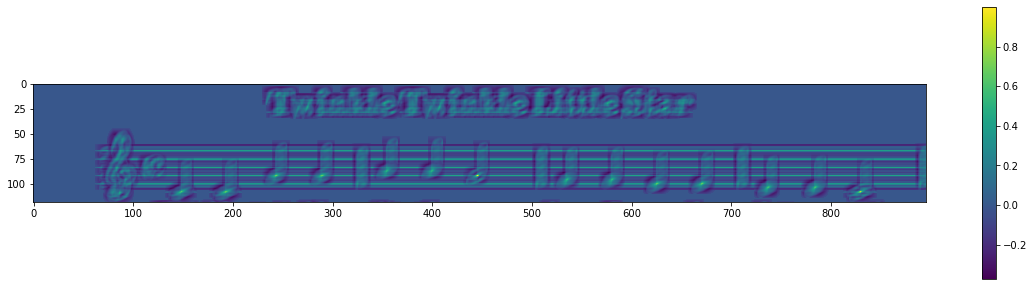

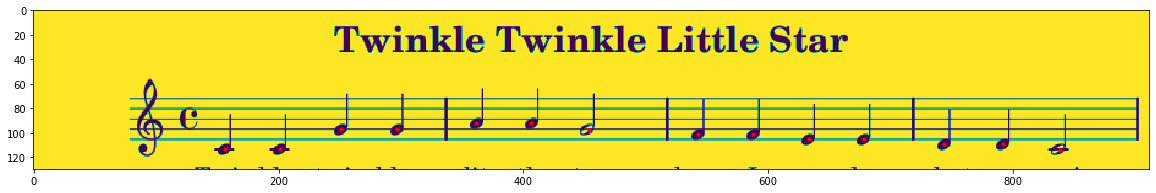

In [113]:


plt.figure(figsize = [20,5])
plt.imshow(section_half)   
plt.plot(CX,, 'r.')

In [114]:
CX, CY, notes_freq

([201,
  156,
  792,
  744,
  678,
  633,
  588,
  543,
  297,
  251,
  406,
  361,
  453.5,
  838.5,
  453.5,
  838.5],
 [113,
  113,
  109,
  109,
  105,
  105,
  101,
  101,
  97,
  97,
  92,
  92,
  98.0,
  114.0,
  98.0,
  114.0],
 [213,
  213,
  392,
  392,
  448,
  448,
  347,
  347,
  302,
  302,
  258,
  258,
  381,
  201,
  381,
  201])

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [95]:
notes_freq

[213, 213, 392, 392, 448, 448, 347, 347, 302, 302, 258, 258, 381, 201]

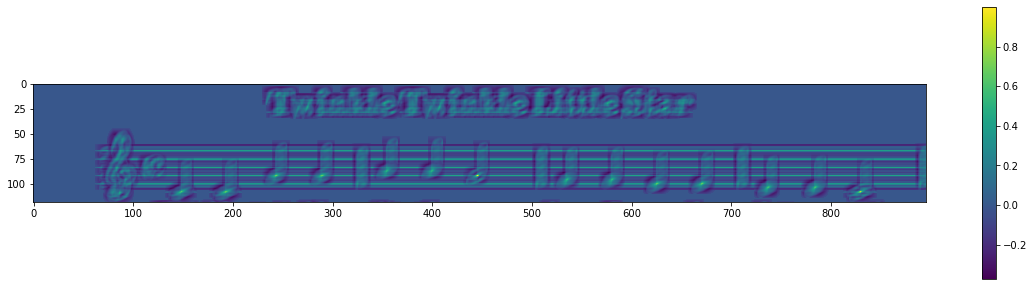

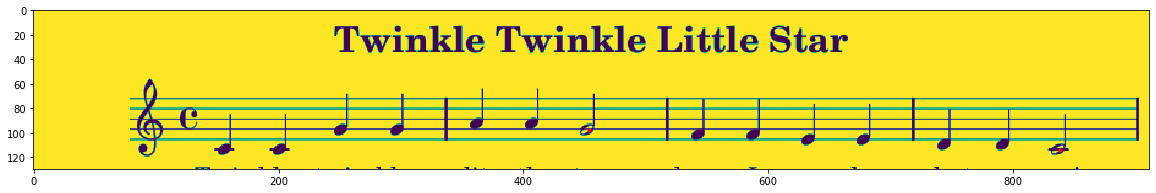

In [78]:
twinkle = cv2.imread("Twinkle_Twinkle_Sheet_Music.png")
twinkle = cv2.cvtColor(twinkle, cv2.COLOR_BGR2GRAY)

s = 0


In [79]:
w,h

(17, 12)

In [40]:
loc

(array([ 92,  92,  92, 108], dtype=int64),
 array([444, 445, 446, 830], dtype=int64))

In [27]:
loc

(array([], dtype=int64), array([], dtype=int64))

In [21]:
loc[0], loc[1]

(array([ 92,  92,  92, 108, 222, 222, 328, 329, 345], dtype=int64),
 array([444, 445, 446, 830, 385, 820, 388, 387, 817], dtype=int64))

In [ ]:
s = 2
section = image[s*shape[0]//sections:(s+1)*shape[0]//3,:]
ret,thresh = cv2.threshold(section.astype('uint8'),0,255,1)
contours,hierarchy = cv2.findContours(thresh, 1, 2)
CX, CY = [],[]
for j in range(len(contours[:])):
    cnt = contours[j]
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    CX.append(cx)
    CY.append(cy)

#     plt.figure(figsize = [20,2])
#     plt.imshow(thresh)
#     plt.plot(CX, CY, 'r.')
#     plt.show()

indices, CX_sorted= zip(*sorted(enumerate(CX), key=itemgetter(1)))
CY_sorted = []
for z in indices:
    CY_sorted.append(CY[z])
    Y_COORD.append(CY[z]+s*shape[0]//sections)
    X_COORD.append(CX[z])


size1 = 100
s1 = np.zeros(shape=[size1,size1])
s1[size1//2,:] = 1

staff = mp.dilation(twinkle[:,:,0],s1)
staff_sec = staff[s*shape[0]//sections:(s+1)*shape[0]//sections,:]


y = np.where(staff_sec[:,500] < 1)[0]
Y = []
for k in range(1,len(y)+1):
    if np.abs(y[k-2]-y[k-1]) > 2:
        Y.append(y[k-1])

In [364]:
y, Y

(array([48, 56, 57, 64, 65, 72, 73, 81], dtype=int64), [48, 56, 64, 72, 81])

In [214]:
X_calib, Y_calib = [],[]

for j in range(len(contours[:])):
    cnt = contours[j]
    M = cv2.moments(cnt)
    cx = int(M['m10']//M['m00'])
    cy = int(M['m01']//M['m00'])
    X_calib.append(cx)
    Y_calib.append(cy)

ZeroDivisionError: float divmod()

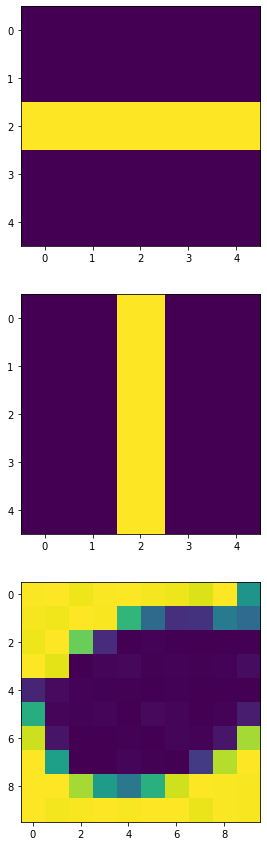

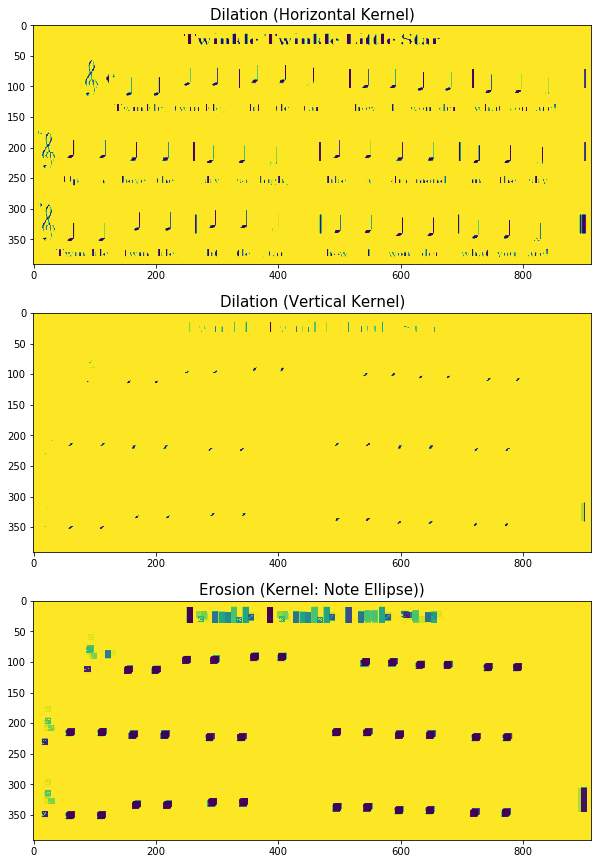

In [115]:
size1 = 5
kernel_1 = np.zeros(shape=[size1,size1])
kernel_1[size1//2,:] = 1

size2 = 5
kernel_2 = np.zeros(shape=[size2,size2])
kernel_2[:, size2//2] = 1

plt.figure(figsize = [10,15])
plt.subplot(3,1,1)
plt.imshow(kernel_1)
plt.subplot(3,1,2)
plt.imshow(kernel_2)
plt.subplot(3,1,3)
plt.imshow(s2)


a = mp.dilation(twinkle, kernel_2)
#a = mp.erosion(a,s2/10)
b = mp.dilation(a, kernel_1)
c = mp.erosion(b,s2)

#threshhold = 125
#c[c<threshhold] = 0
plt.figure(figsize = [10,15])
plt.subplot(3,1,1)
plt.title("Dilation (Horizontal Kernel)")
plt.imshow(a)
plt.subplot(3,1,2)
plt.title("Dilation (Vertical Kernel)")
plt.imshow(b)
plt.subplot(3,1,3)
plt.title("Erosion (Kernel: Note Ellipse))")
plt.imshow(c)
plt.show()

In [182]:
ret,thresh = cv2.threshold(staff_sec.astype('uint8'),0,255,1)
contours,hierarchy = cv2.findContours(thresh, 1, 2)
X_calib, Y_calib = [],[]

for j in range(len(contours[:])):
    cnt = contours[j]
    M = cv2.moments(cnt)
    cx = int(M['m10']//M['m00'])
    cy = int(M['m01']//M['m00'])
    X_calib.append(cx)
    Y_calib.append(cy)
    
plt.figure(figsize = [20,10])
plt.imshow(staff_sec)

ZeroDivisionError: float divmod()

In [155]:
len(contours[:])

5

In [176]:
cnt = contours[5]
M = cv2.moments(cnt)
#cx = int(M['m10']/M['m00'])
#cy = int(M['m01']/M['m00'])
#cx, cy
M

IndexError: list index out of range

In [170]:
M

{'m00': 0.0,
 'm01': 0.0,
 'm02': 0.0,
 'm03': 0.0,
 'm10': 0.0,
 'm11': 0.0,
 'm12': 0.0,
 'm20': 0.0,
 'm21': 0.0,
 'm30': 0.0,
 'mu02': 0.0,
 'mu03': 0.0,
 'mu11': 0.0,
 'mu12': 0.0,
 'mu20': 0.0,
 'mu21': 0.0,
 'mu30': 0.0,
 'nu02': 0.0,
 'nu03': 0.0,
 'nu11': 0.0,
 'nu12': 0.0,
 'nu20': 0.0,
 'nu21': 0.0,
 'nu30': 0.0}

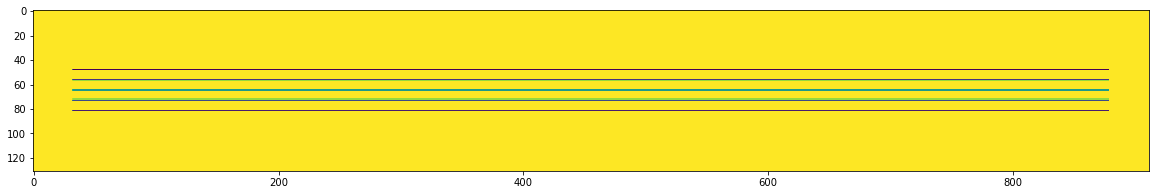

In [163]:
plt.figure(figsize = [20,10])
plt.imshow(staff_sec)

In [121]:
Y_calib


[104, 96, 87, 79, 71]

In [116]:
freq = [698, 587, 494, 392, 330]

z1 = np.polyfit(pix1, freq, 1)
p1 = np.poly1d(z1)

plt.plot(pix1, freq, 'ro')
plt.plot(pix1, p1(pix1), 'k-')

def pix_to_freq_1(pix):
    return pix*p1[1] + p1[0]

[490, 490, 490, 490, 490]

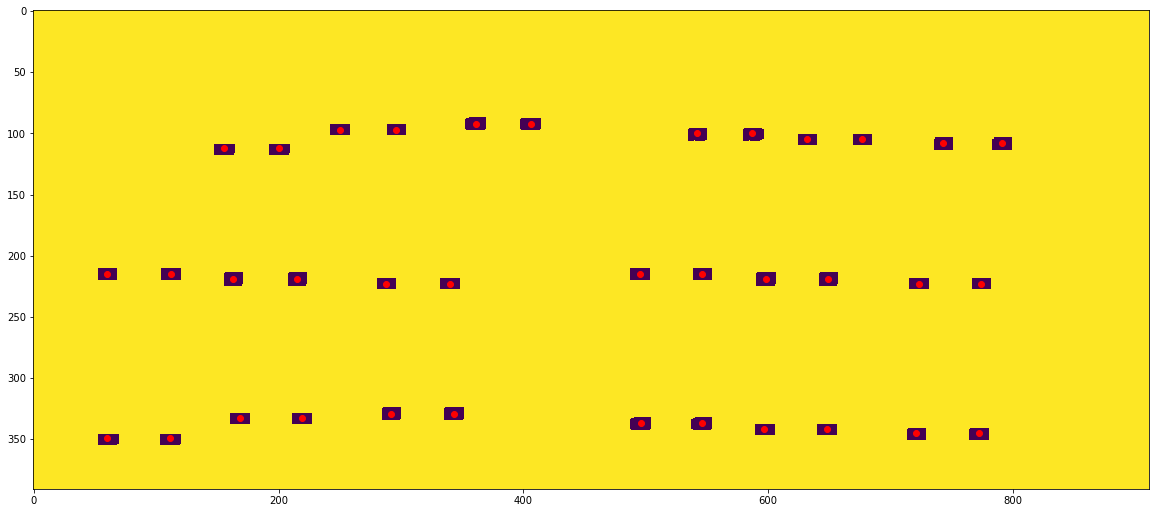

In [50]:
plt.figure(figsize = [20,10])

A = []
CX, CY = [],[]
for i in range(len(contours[:])):
    cnt = contours[i]
    area = cv2.contourArea(cnt)
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    A.append(area)
    CX.append(cx)
    CY.append(cy)

plt.imshow(notes)
plt.plot(CX, CY, 'ro')

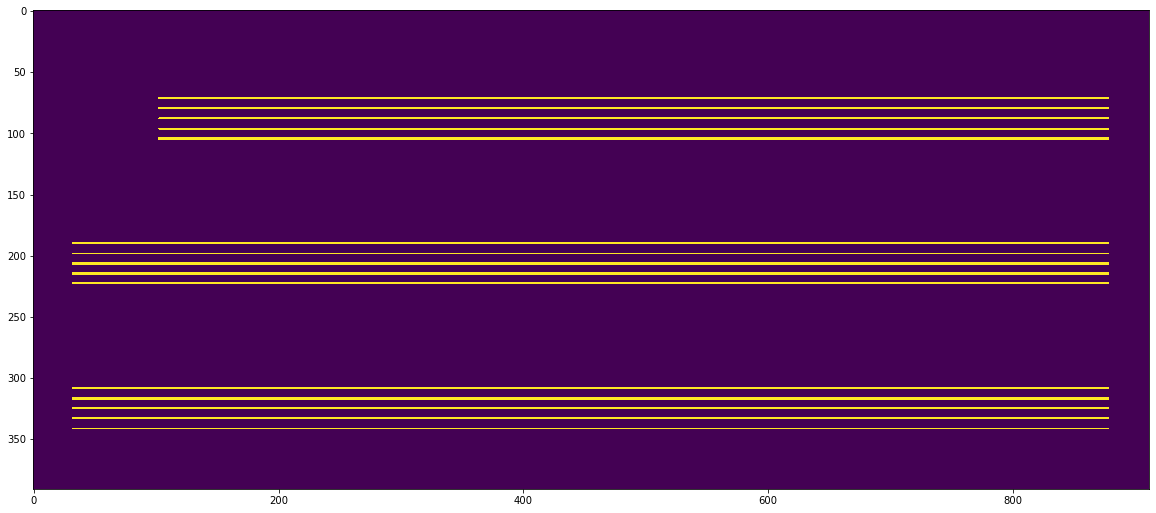

In [97]:
plt.figure(figsize = [20,10])

size1 = 50
s1 = np.zeros(shape=[size1,size1])
s1[size1//2,:] = 1

staff = mp.dilation(twinkle[:,:,0],s1)

ret_s,thresh_s = cv2.threshold(staff.astype('uint8'),0,1,1)
contours_s,hierarchy_s = cv2.findContours(thresh_s, 1, 4)
plt.imshow(thresh_s)


(array([ 71,  72,  79,  80,  87,  88,  96,  97, 104, 105, 189, 190, 198,
        206, 207, 214, 215, 222, 223, 308, 316, 317, 324, 325, 332, 333,
        341], dtype=int64),)

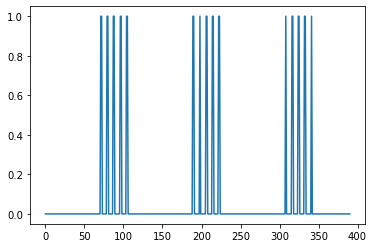

In [98]:
plt.plot(thresh_s[:,500])
np.where(thresh_s[:,500]==1)

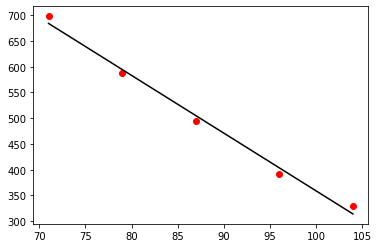

In [99]:
#1st Staff
# [F5,D5,B5,G4,E4]
pix1 = [71, 79, 87, 96, 104]
freq = [698, 587, 494, 392, 330]

z1 = np.polyfit(pix1, freq, 1)
p1 = np.poly1d(z1)

plt.plot(pix1, freq, 'ro')
plt.plot(pix1, p1(pix1), 'k-')

def pix_to_freq_1(pix):
    return pix*p1[1] + p1[0]

In [ ]:
f_1 = []
for i in range(8):
    f_1.append(int(pix_to_freq_1(np.flip(CY))[i]))
f_1

In [ ]:
size1 = 9
s1 = np.zeros(shape=[size1,size1])
s1[size1//2,:] = 1

size2 = 5
s2 = np.zeros(shape=[size2,size2])
s2[:, size2//2] = 1

plt.subplot(1,2,1)
plt.imshow(s1)
plt2subplot(1,2,2)
plt.imshow(s2)

In [ ]:
a = mp.dilation(notes, s1)
b = mp.dilation(a, s2)
c = mp.erosion(b,s3[:,0])
#a = mp.dilation(notes, s2)
#c = mp.erosion(a,s4[:,:,0])

threshhold = 200
c[c<threshhold] = 0
plt.figure(figsize = [10,20])
plt.imshow(a)
# plt.figure(figsize = [10,20])
# plt.imshow(b)
# plt.show()
plt.figure(figsize = [10,20])
plt.imshow(c)
plt.show()

In [ ]:
d = cv2.Canny(c,threshhold,255)
plt.figure(figsize = [20,20])
plt.imshow(d)

In [ ]:
plt.figure(figsize = [20,20])
ret,thresh = cv2.threshold(c,100, 255,0)
contours,hierarchy = cv2.findContours(thresh, 1, 2)
plt.imshow(thresh)

In [ ]:
notes.dtype